In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train', 'train.csv', 'sample_submission.csv']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow as tf
import os

plt.style.use('ggplot')

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/sample_submission.csv')

In [4]:
train['has_cactus'] = train['has_cactus'].astype('str')
train['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train_df, valid_df = train_test_split(train, test_size=0.1, stratify=train['has_cactus'], random_state=42)

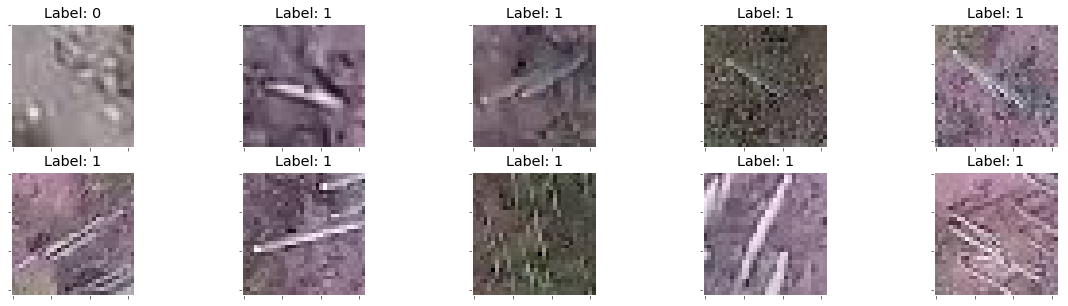

In [7]:
rows, cols = (2, 5)

fig, ax = plt.subplots(rows,cols,figsize=(20,5))

for j in range(rows):
    for i, sample in enumerate(train_df[j * cols:rows * cols - (cols * (rows - (j + 1)))].values):
        path = os.path.join('../input/train/train', sample[0])
        ax[j][i].imshow(img.imread(path))
        ax[j][i].set_title('Label: ' + str(sample[1]))
        ax[j][i].grid(False)
        ax[j][i].set_xticklabels([])
        ax[j][i].set_yticklabels([])

In [8]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., 
                                                                vertical_flip=True, horizontal_flip=True,)
datagen_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [9]:
img_size = 224

In [10]:
train_data = datagen_train.flow_from_dataframe(dataframe=train_df, directory='../input/train/train',
                                               x_col='id', y_col='has_cactus', batch_size=64,
                                               class_mode='binary', target_size=(img_size, img_size))


validation_data = datagen_valid.flow_from_dataframe(dataframe=valid_df,directory='../input/train/train',
                                                    x_col='id', y_col='has_cactus', batch_size=64,
                                                    class_mode='binary', target_size=(img_size, img_size))

Found 15750 images belonging to 2 classes.
Found 1750 images belonging to 2 classes.


In [11]:
model_vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(img_size, img_size, 3))

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step


In [12]:
for layer in model_vgg16.layers:
    layer.trainable = False

In [13]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.3)
leaky_relu.__name__ = 'leaky_relu'
flat1 = tf.keras.layers.Flatten()(model_vgg16.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation=leaky_relu)(flat1)
drop1 = tf.keras.layers.Dropout(0.5)(class1)
class2 = tf.keras.layers.Dense(256, activation=leaky_relu)(drop1)
drop2 = tf.keras.layers.Dropout(0.5)(class2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model_vgg16 = tf.keras.models.Model(inputs=model_vgg16.inputs, outputs=output)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
adadelta = tf.keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
model_vgg16.compile(optimizer=adadelta, loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_best_model.h5",
                                                   save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [17]:
history = model_vgg16.fit(train_data, epochs=50,
                          validation_data=validation_data, 
                          callbacks=[checkpoint_cb, early_stopping_cb])

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
247/247 [==============================] - 64s 259ms/step - loss: 0.4557 - acc: 0.8570 - val_loss: 0.5064 - val_acc: 0.8229
Epoch 2/50
247/247 [==============================] - 53s 217ms/step - loss: 0.2100 - acc: 0.9239 - val_loss: 0.1896 - val_acc: 0.9211
Epoch 3/50
247/247 [==============================] - 53s 217ms/step - loss: 0.1743 - acc: 0.9364 - val_loss: 0.0884 - val_acc: 0.9680
Epoch 4/50
247/247 [==============================] - 53s 214ms/step - loss: 0.1379 - acc: 0.9486 - val_loss: 0.1207 - val_acc: 0.9537
Epoch 5/50
247/247 [==============================] - 53s 216ms/step - loss: 0.1200 - acc: 0.9510 - val_loss: 0.0907 - val_acc: 0.9651
Epoch 6/50
247/247 [==============================] - 53s 215ms/step - loss: 0.1144 - acc: 0.9570 - val_loss: 0.0839 - val_acc: 0.9726
Epoch 7/50
247/247 [==============================] - 53s 216ms/step - loss: 0.0984 - acc: 0.9629 - val_loss: 0.0772 - val_acc: 0.9749
Epoch 8

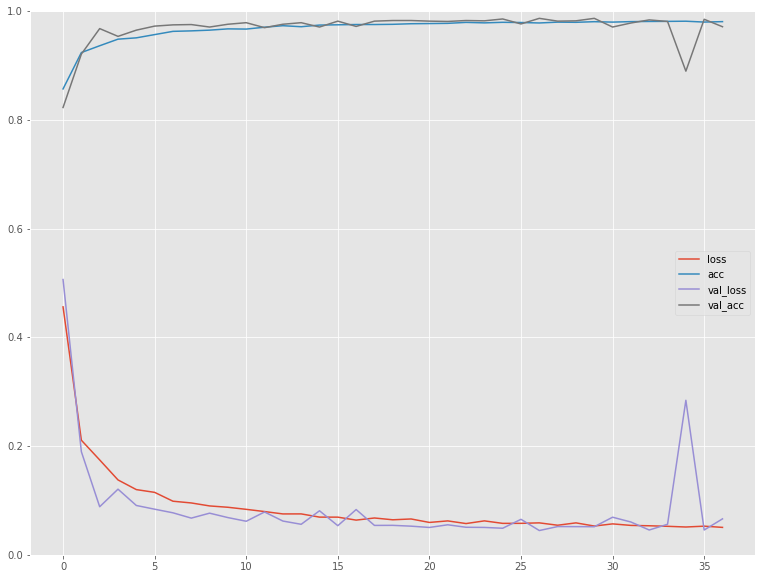

In [18]:
history_df = pd.DataFrame(history.history)
history_df.plot(figsize=(13, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [19]:
test_data = datagen_valid.flow_from_dataframe(dataframe=test, directory="../input/test/test",
                                              x_col="id", y_col=None, shuffle=False, 
                                              class_mode=None, target_size=(img_size, img_size))

Found 4000 images.


In [20]:
answer = pd.DataFrame({'id': test['id']})

In [21]:
answer['has_cactus'] = model_vgg16.predict(test_data, verbose=True)

125/125 [==============================] - 14s 109ms/step


In [22]:
answer.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.999129
1,0017242f54ececa4512b4d7937d1e21e.jpg,1.000000
2,001ee6d8564003107853118ab87df407.jpg,0.022793
3,002e175c3c1e060769475f52182583d0.jpg,0.004924
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.823280


In [23]:
answer.to_csv('submission.csv',  sep=',' , line_terminator='\n', index=False)